**Forensic Scanner Identification Using CASIA Datasets**

Datasets
[CASIA2](https://drive.google.com/drive/folders/1p--NIVEPSBiQKGlrr_OrDydD1JXKoUTG?usp=sharing)
[CASIA1](https://drive.google.com/drive/folders/1vnyghsrVytqNvAqCDnkx1409UCKodenu?usp=sharing)

Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing the Packages**

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


Function to get list of images in folder path

In [ ]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

**Converting the images to Error Level Analysis**

In [ ]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

Exploring the Image Data

In [ ]:
from tqdm import tqdm
path_original = '/content/drive/MyDrive/project/CASIA1/Au/'
path_tampered = '/content/drive/MyDrive/project/CASIA1/Sp/'

total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [ ]:
images = []
for file in tqdm(os.listdir(path_original)):
  try:
    if file.endswith('jpg'):
      if int(os.stat(path_original + file).st_size) > 10000:
        line = path_original + file + ',1\n'
        images.append(line)
      if file.endswith('tif'):
        if int(os.stat(path_original + file).st_size) > 10000:
          line = path_original + file + ',1\n'
          images.append(line)
  except:
    print(path_original+file)

100%|██████████| 800/800 [00:00<00:00, 6311.92it/s]


In [ ]:
for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        if file.endswith('tif'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
    except:
          print(path_tampered+file)

100%|██████████| 923/923 [00:00<00:00, 6411.91it/s]


In [ ]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████| 1705/1705 [00:00<00:00, 740069.16it/s]


**Feature Extraction using Dataframe**

In [ ]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})
dataset.to_csv('/content/drive/MyDrive/project/dataset.csv',index=False)
dataset = pd.read_csv('/content/drive/MyDrive/project/dataset.csv')

In [ ]:
dataset.head()

,image,class_label
0,/content/drive/MyDrive/project/CASIA1/Au/Au_tx...,1
1,/content/drive/MyDrive/project/CASIA1/Au/Au_tx...,1
2,/content/drive/MyDrive/project/CASIA1/Au/Au_tx...,1
3,/content/drive/MyDrive/project/CASIA1/Au/Au_tx...,1
4,/content/drive/MyDrive/project/CASIA1/Au/Au_tx...,1


In [ ]:
X = []
Y = []

In [ ]:
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((60, 60))).flatten() / 255.0)
    Y.append(row[1])

X = np.array(X)
Y = to_categorical(Y, 2)

In [ ]:
X = X.reshape(-1, 60, 60, 3)

Splitting  the Datas 

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

**Deploying the CNN**

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu', input_shape = (60,60,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(60, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 52, 16)        6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 26, 26, 16)        0         
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 60)                649020    
                                                        

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 5,validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/5
14/14 - 12s - loss: 0.0746 - accuracy: 0.9765 - val_loss: 1.7479e-09 - val_accuracy: 1.0000 - 12s/epoch - 880ms/step
Epoch 2/5
14/14 - 0s - loss: 9.6137e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 172ms/epoch - 12ms/step
Epoch 3/5
14/14 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 180ms/epoch - 13ms/step
Epoch 4/5
14/14 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 177ms/epoch - 13ms/step
Epoch 5/5
14/14 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 172ms/epoch - 12ms/step


**Generating the Model File**

In [ ]:
model.save('/content/drive/MyDrive/project/detector.h5')

Precision And Re-call score for the Model

In [ ]:
from sklearn import metrics
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1) 

score = metrics.precision_score(Y_true,y_pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred, average= "weighted")
print("Recall score: {}".format(score))
score_f1 = metrics.f1_score(Y_true, y_pred, average= "weighted")
print("F1 score: {}".format(score_f1))

Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [ ]:
cm = confusion_matrix(Y_true, y_pred)
print('Confusion matrix:\n',cm)

Confusion matrix:
 [[341]]


In [ ]:
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


Prediction With the Model for the input Image

In [ ]:
path_original = '/content/drive/MyDrive/project/CASIA1/Au/Au_ani_0001.jpg'
path_tampered = '/content/drive/MyDrive/project/CASIA1/Sp/Sp_D_CNN_A_ani0049_ani0084_0266.jpg'

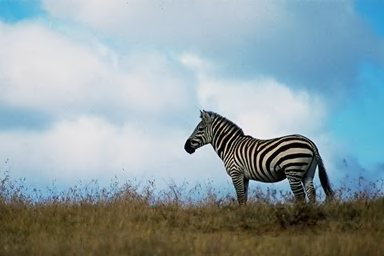

In [ ]:
orig_img = Image.open('/content/drive/MyDrive/project/CASIA1/Au/Au_ani_0001.jpg')
display(orig_img)

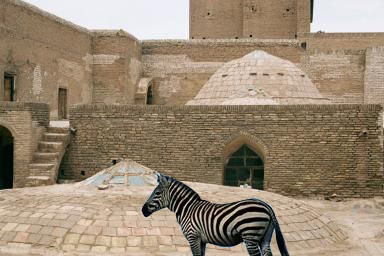

In [ ]:
orig_img = Image.open('/content/drive/MyDrive/project/CASIA1/Sp/Sp_D_NRN_A_ani0001_arc0059_0404.jpg')
display(orig_img)

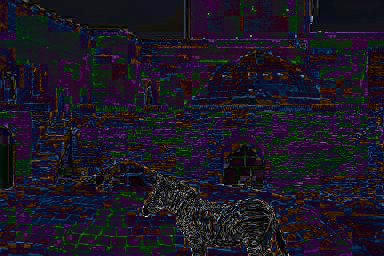

In [ ]:
convert_to_ela_image('/content/drive/MyDrive/project/CASIA1/Sp/Sp_D_NRN_A_ani0001_arc0059_0404.jpg',1)

In [ ]:
X_f = []

In [ ]:
X_f.append(np.array(convert_to_ela_image(path_original,90).resize((60, 60))).flatten() / 255.0)

In [ ]:
X_f = np.array(X_f)

In [ ]:
X_f = X_f.reshape(-1, 60, 60, 3)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/project/detector.h5')

In [ ]:
y_pred_test = model.predict(X_f)
y_pred_test = np.argmax(y_pred_test,axis = 1)

In [ ]:
print(y_pred_test)

[1]
